AUTOR: DIEGO BERNALES VALDIVIA - TRABAJO FINAL TIME SERIES

# OBJETIVO



*   Realizar el análisis y pronóstico de una serie de tiempo univariada.
*   Utilizar al menos 4 modelos distintos
*   Pronosticar las ventas totales mensuales para la tienda con mayores ventas acumuladas hasta la última fecha del dataset



In [3]:
#IMPORTACIÓN DE LIBRERÍAS
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
import seaborn as sns

import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [5]:
#FUNCIÓN DE EVALUACIÓN
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [6]:
# dataframe para guardar los pronosticos y compararlos con la data real
data_test_proy = pd.DataFrame() 

## LECTURA INICIAL Y LIMPIEZA

In [7]:
df_sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datos/SalesDemand.csv', delimiter= ';' ,low_memory=False)

In [6]:
df_sales

,date,store,item,sales
0,1/01/2013,1.0,1.0,13.0
1,2/01/2013,1.0,1.0,11.0
2,3/01/2013,1.0,1.0,14.0
3,4/01/2013,1.0,1.0,13.0
4,5/01/2013,1.0,1.0,10.0
...,...,...,...,...
957995,NaN,NaN,NaN,NaN
957996,NaN,NaN,NaN,NaN
957997,NaN,NaN,NaN,NaN
957998,NaN,NaN,NaN,NaN


In [ ]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958000 entries, 0 to 957999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    913000 non-null  object 
 1   store   913000 non-null  float64
 2   item    913000 non-null  float64
 3   sales   913000 non-null  float64
dtypes: float64(3), object(1)
memory usage: 29.2+ MB


In [8]:
df_sales = df_sales.dropna()

In [9]:
df_sales.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
df_sales

,date,store,item,sales
0,1/01/2013,1.0,1.0,13.0
1,2/01/2013,1.0,1.0,11.0
2,3/01/2013,1.0,1.0,14.0
3,4/01/2013,1.0,1.0,13.0
4,5/01/2013,1.0,1.0,10.0
...,...,...,...,...
912995,27/12/2017,10.0,50.0,63.0
912996,28/12/2017,10.0,50.0,59.0
912997,29/12/2017,10.0,50.0,74.0
912998,30/12/2017,10.0,50.0,62.0


In [ ]:
df_sales.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


* Vemos que la venta máxima diaria en general para las tiendas fue de 231, la mínima de cero y en promedio 52.25.
* Se observa que tenemos  10 tiendas y 50 productos.

## ARMANDO BASE DE PRONÓSTICO

* Ya que el objetivo es pronosticar las ventas mensuales de las tiendas procedemos a extraer los meses de cada fecha y agrupar la suma de ventas por tienda y año/mes.

In [9]:
df_sales['date'] = pd.to_datetime(df_sales['date'], format='%d/%m/%Y')

In [10]:
df_sales['fecha'] = pd.to_datetime(df_sales['date'].apply(lambda x: x.strftime('%Y-%m')))

In [ ]:
df_sales.head()

,date,store,item,sales,fecha
0,2013-01-01,1.0,1.0,13.0,2013-01-01
1,2013-01-02,1.0,1.0,11.0,2013-01-01
2,2013-01-03,1.0,1.0,14.0,2013-01-01
3,2013-01-04,1.0,1.0,13.0,2013-01-01
4,2013-01-05,1.0,1.0,10.0,2013-01-01


In [11]:
df_salesGroup = df_sales.groupby(['fecha','store'], as_index=False).agg({'sales':sum})

In [13]:
df_salesGroup.head(31)

,fecha,store,sales
0,2013-01-01,1.0,41077.0
1,2013-01-01,2.0,58520.0
2,2013-01-01,3.0,51972.0
3,2013-01-01,4.0,47720.0
4,2013-01-01,5.0,34405.0
5,2013-01-01,6.0,34944.0
6,2013-01-01,7.0,31508.0
7,2013-01-01,8.0,56043.0
8,2013-01-01,9.0,47620.0
9,2013-01-01,10.0,51095.0


In [14]:
# Fecha mínima y máximo:
print(df_salesGroup['fecha'].min())
print(df_salesGroup['fecha'].max())

2013-01-01 00:00:00
2017-12-01 00:00:00


### Gráfico de ventas totales de la empresa

<AxesSubplot:xlabel='fecha', ylabel='sales'>

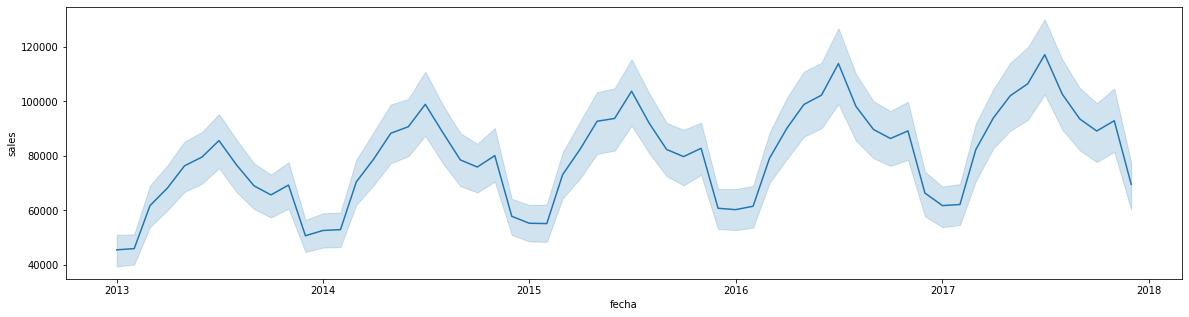

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(x="fecha", y="sales", data=df_salesGroup)

In [ ]:
df_salesGroup.groupby(["store"]).sum() 

,sales
store,
1.0,4315603.0
2.0,6120128.0
3.0,5435144.0
4.0,5012639.0
5.0,3631016.0
6.0,3627670.0
7.0,3320009.0
8.0,5856169.0
9.0,5025976.0


* Se observa que la tienda 2 tiene las ventas acumuladas mayores del grupo. Por ello será elegida para el ejercició de pronóstico.

In [12]:
df_store2 = df_salesGroup[df_salesGroup.store == 2]
df_store2.head()

,fecha,store,sales
1,2013-01-01,2.0,58520.0
11,2013-02-01,2.0,59384.0
21,2013-03-01,2.0,79609.0
31,2013-04-01,2.0,87987.0
41,2013-05-01,2.0,98361.0


## ANÁLISIS EXPLORATORIO

In [ ]:
df_store2['sales'].describe()

count        60.000000
mean     102002.133333
std       22154.180550
min       58520.000000
25%       84877.500000
50%      102531.500000
75%      118364.500000
max      150105.000000
Name: sales, dtype: float64

### Gráfico de ventas mensuales de la tienda 2:

<AxesSubplot:xlabel='fecha', ylabel='sales'>

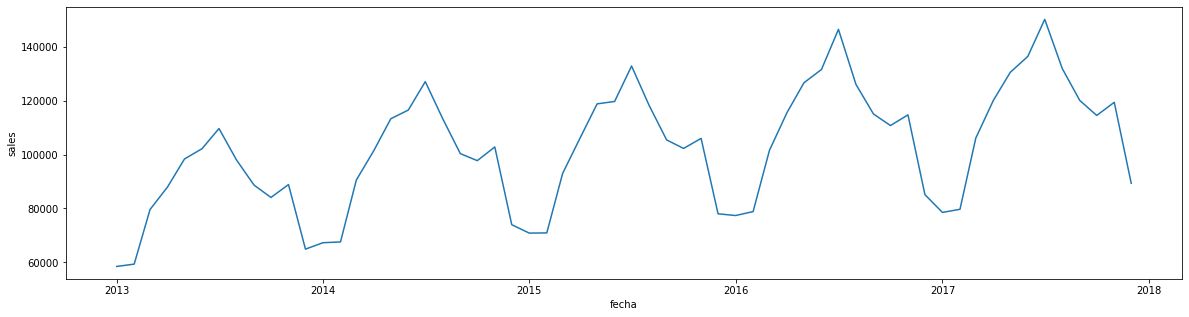

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(x="fecha", y="sales", data=df_store2)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


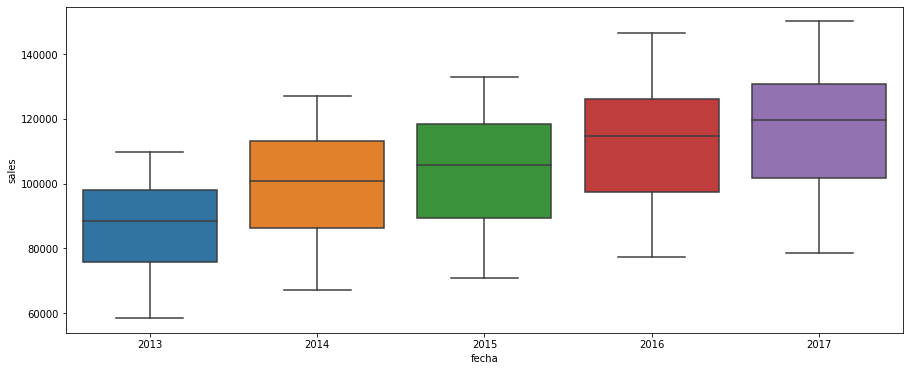

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot( df_store2['fecha'].dt.year, df_store2.sales, ax=ax)
plt.show()

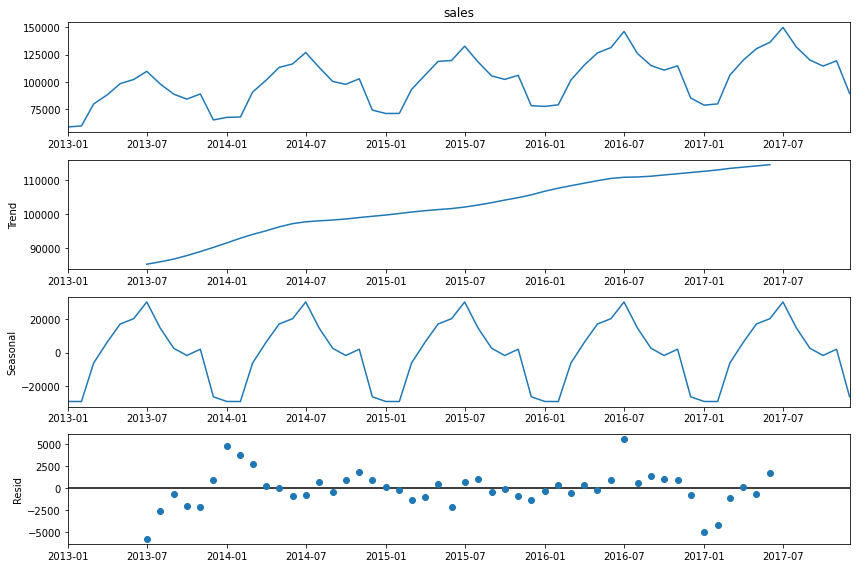

In [ ]:
df_decompose = df_store2.set_index('fecha')
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_decompose["sales"], model = "add")
a.plot();



*  Se observa una tendencia a la alza conforme incrementan los años.
*  También se puede ver cierto comportamiento estacional anualmente.
*  La mayor parte de los residuos se encuentran cerca al cero.



### Prueba  Dickey-Fuller aumentada

Al aceptar la hipótesis nula, aceptamos la evidencia de que los datos de la serie temporal no son estacionarios. Al rechazar la hipótesis nula o aceptar la hipótesis alternativa, aceptamos la evidencia de que los datos de la serie de tiempo son generados por un proceso estacionario. Este proceso también se conoce como tendencia estacionaria. 

In [ ]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [ ]:
Prueba_Dickey_Fuller(df_store2["sales"],"sales")

Resultados de la prueba de Dickey-Fuller para columna: sales
Test Statistic                        -4.895429
p-value                                0.000036
No Lags Used                          11.000000
Número de observaciones utilizadas    48.000000
Critical Value (1%)                   -3.574589
Critical Value (5%)                   -2.923954
Critical Value (10%)                  -2.600039
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


* Según la prueba, podemos concluir que nuestra data es estacionaria. Es decir  que sus propiedades son constantes conforme pasa el tiempo.

### Separando dataframe en train y valid:

In [13]:
y = df_store2.set_index('fecha')
y.drop(columns = 'store', inplace = True) # eliminamos la columna store, ya que no servirá para pronosticar
y

,sales
fecha,
2013-01-01,58520.0
2013-02-01,59384.0
2013-03-01,79609.0
2013-04-01,87987.0
2013-05-01,98361.0
2013-06-01,102158.0
2013-07-01,109645.0
2013-08-01,97992.0
2013-09-01,88673.0


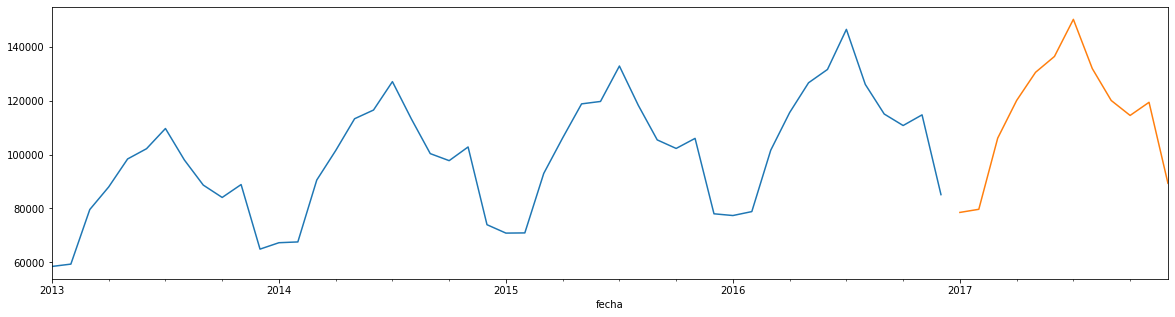

In [14]:
#divide into train and validation set
train = y[:int(0.80*(len(y)))] #entrenamos con 4 años
valid = y[int(0.80*(len(y))):] # compararemos los prnósticos en base a 12 periodos

#plotting the data
plt.figure(figsize=(20,5))
train['sales'].plot()
valid['sales'].plot()
plt.show()

## PROPHET

In [92]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.sales.values
train_prophet.tail()

,ds,y
43,2016-08-01,125985.0
44,2016-09-01,115018.0
45,2016-10-01,110753.0
46,2016-11-01,114705.0
47,2016-12-01,85139.0


In [19]:
valid

,sales
fecha,
2017-01-01,78544.0
2017-02-01,79702.0
2017-03-01,106083.0
2017-04-01,120031.0
2017-05-01,130474.0
2017-06-01,136355.0
2017-07-01,150105.0
2017-08-01,131863.0
2017-09-01,120038.0


In [96]:
start_index = valid.index.min()
end_index = valid.index.max()

In [93]:
import os
# Let cmdstanpy know where CmdStan is
os.environ["CMDSTAN"] = "./cmdstan-2.23.0"

from prophet import Prophet

* LLenando campos de dataframe data_test_proy

In [15]:
data_test_proy['fecha'] = valid.index
data_test_proy['ventas_reales'] = valid.sales.values

In [21]:
data_test_proy

,fecha,ventas_reales
0,2017-01-01,78544.0
1,2017-02-01,79702.0
2,2017-03-01,106083.0
3,2017-04-01,120031.0
4,2017-05-01,130474.0
5,2017-06-01,136355.0
6,2017-07-01,150105.0
7,2017-08-01,131863.0
8,2017-09-01,120038.0
9,2017-10-01,114492.0


### Modelo 1 :

In [97]:
#instantiate Prophet with only yearly seasonality as our data is monthly 
model = Prophet()
model.fit(train_prophet) #fit the model 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24exo6mr/3yxz59_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24exo6mr/j87d3x30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39315', 'data', 'file=/tmp/tmp24exo6mr/3yxz59_d.json', 'init=/tmp/tmp24exo6mr/j87d3x30.json', 'output', 'file=/tmp/tmp24exo6mr/prophet_model6fwvmf6r/prophet_model-20230225214017.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:40:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [100]:
future = model.make_future_dataframe(periods = 12, freq='MS') 
future.tail(12)

,ds
48,2017-01-01
49,2017-02-01
50,2017-03-01
51,2017-04-01
52,2017-05-01
53,2017-06-01
54,2017-07-01
55,2017-08-01
56,2017-09-01
57,2017-10-01


In [99]:
# haciendo predicciones
forecast = model.predict(future)
forecast[['ds', 'yhat']]

,ds,yhat
0,2013-01-01,58282.251033
1,2013-02-01,57950.162849
2,2013-03-01,77405.283318
3,2013-04-01,88580.725239
4,2013-05-01,99318.601084
5,2013-06-01,102935.879617
6,2013-07-01,114282.984744
7,2013-08-01,98946.490559
8,2013-09-01,88423.565307
9,2013-10-01,84938.368291


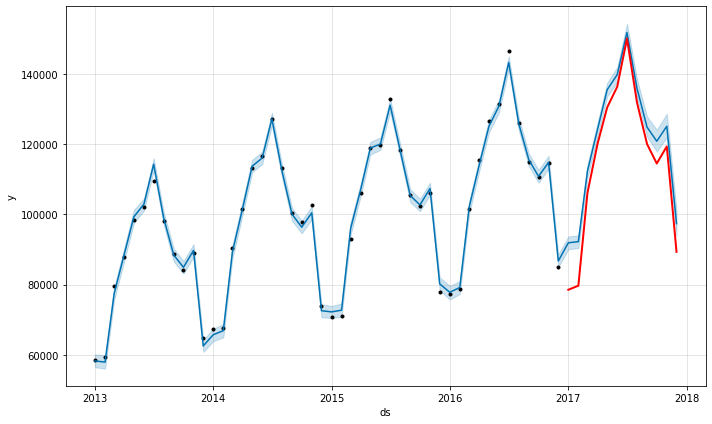

In [ ]:
fig = model.plot(forecast)
#plot the predictions for validation set
plt.plot(valid, label='Valid', color = 'red', linewidth = 2)

plt.show()

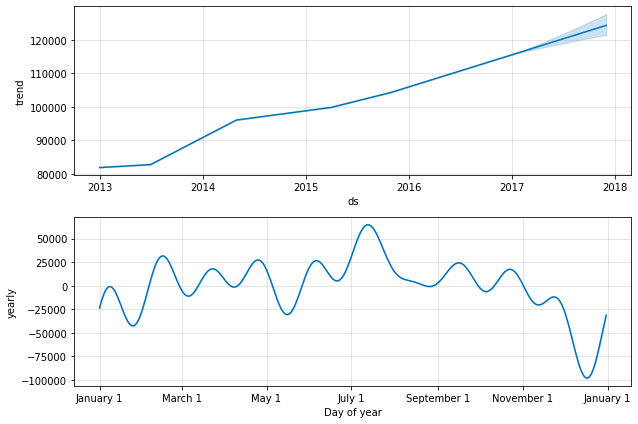

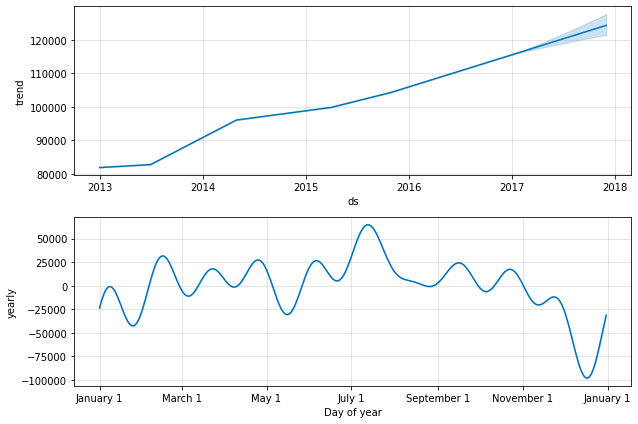

In [ ]:
model.plot_components(forecast)

* Vemos que el modelo asume una tendencia positiva. 
* Y un comportamiento mensual que se repite cada año.

* Evaluando predicciones en valid:

In [107]:
evaluate_forecast(y[start_index:end_index], forecast[-12:]["yhat"])

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,rmse
0,0.891208,6278.03347,5390.29193,5.071474e+07,0.005632,7121.428139


### Modelo 2:

In [94]:
#definiendo que la estacionalidad sea anual y el modelo multiplicativo
model2 = Prophet(yearly_seasonality=True,seasonality_mode= 'multiplicative')
model2.fit(train_prophet) #fit the model with your dataframe

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24exo6mr/zj8eekip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24exo6mr/wtjhp6o6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66824', 'data', 'file=/tmp/tmp24exo6mr/zj8eekip.json', 'init=/tmp/tmp24exo6mr/wtjhp6o6.json', 'output', 'file=/tmp/tmp24exo6mr/prophet_model1k7jy0em/prophet_model-20230225213744.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:37:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


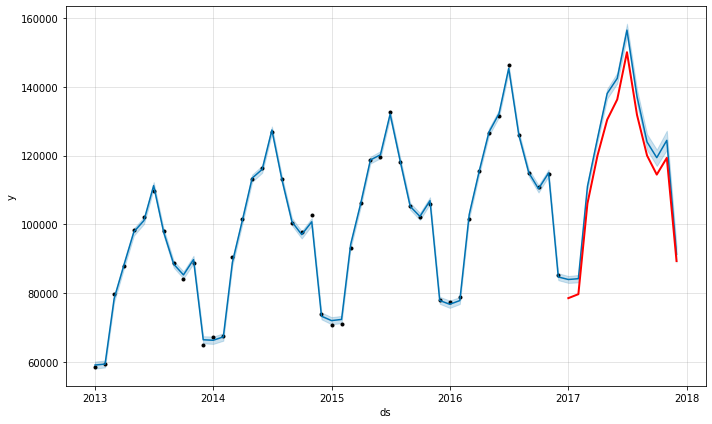

In [95]:
future = model2.make_future_dataframe(periods = 12, freq = 'MS') 
forecast2 = model2.predict(future)
fig = model2.plot(forecast2)
#plot the predictions for validation set

plt.plot(valid, label='Valid', color = 'red', linewidth = 2)

plt.show()

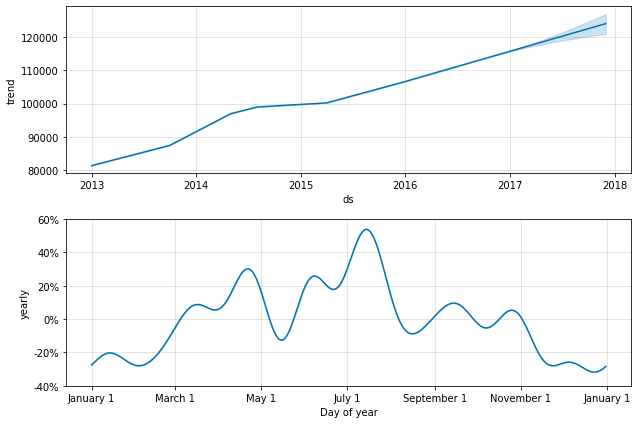

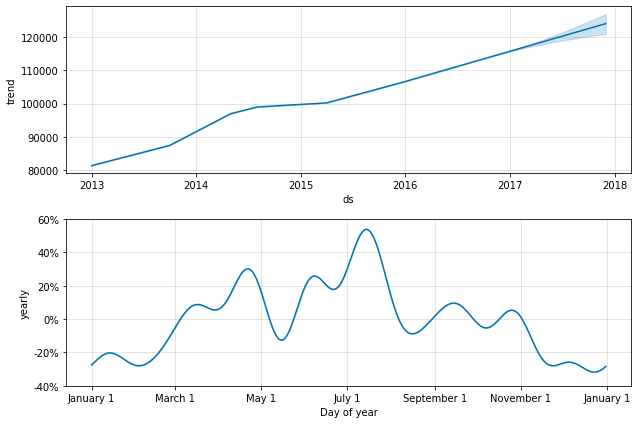

In [ ]:
model2.plot_components(forecast2)

* Evaluando predicciones en valid:

In [106]:
evaluate_forecast(y[start_index:end_index], forecast2[-12:]["yhat"])

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,rmse
0,0.940254,5109.316329,5029.619475,2.785139e+07,0.002063,5277.441696


* Notamos que al agregar seasonality_mode= 'multiplicative' , las métricas de predicción mejoran.
* Esto se debe a que el modelo asume un comportamiento distinto para los meses y la tendencia.

In [27]:
#extraemos ultimas 12 predicciones
prophet_pred = pd.DataFrame({"Date" : forecast2[-12:]['ds'], "Pred" : forecast2[-12:]["yhat"]})
prophet_pred

,Date,Pred
48,2017-01-01,83970.184349
49,2017-02-01,84207.135212
50,2017-03-01,111035.397322
51,2017-04-01,124989.670997
52,2017-05-01,138098.783411
53,2017-06-01,142484.037024
54,2017-07-01,156526.347595
55,2017-08-01,137226.535607
56,2017-09-01,123977.580282
57,2017-10-01,119417.600437


In [28]:
data_test_proy["Prophet_Predictions"] = prophet_pred['Pred'].values

In [29]:
data_test_proy

,fecha,ventas_reales,Prophet_Predictions
0,2017-01-01,78544.0,83970.184349
1,2017-02-01,79702.0,84207.135212
2,2017-03-01,106083.0,111035.397322
3,2017-04-01,120031.0,124989.670997
4,2017-05-01,130474.0,138098.783411
5,2017-06-01,136355.0,142484.037024
6,2017-07-01,150105.0,156526.347595
7,2017-08-01,131863.0,137226.535607
8,2017-09-01,120038.0,123977.580282
9,2017-10-01,114492.0,119417.600437


## SARIMA

### Gráficos de Autocorrelación y Autocorrelación Parcial

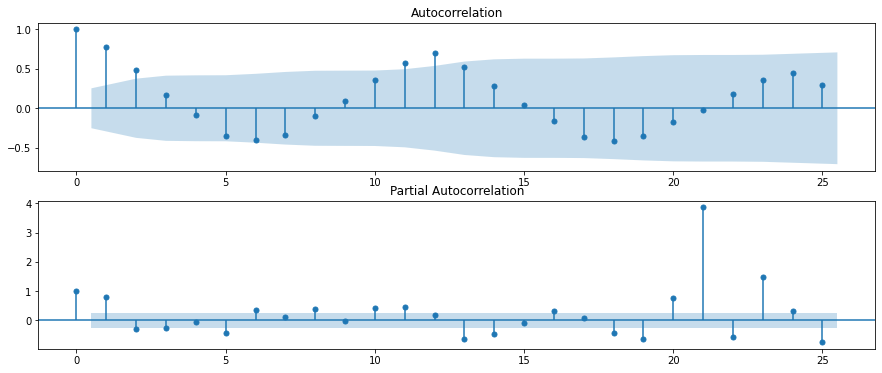

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(211)
plot_acf(y.sales, ax=plt.gca(), lags = 25)
plt.subplot(212)
plot_pacf(y.sales, ax=plt.gca(), lags = 25)
plt.show()

* Según el gráfico ACF, la bajada de valores de los lags tiende a bajar y subir cada 12 puntos ( esto es debido a la estacionalidad hallada previamente) por lo que hay tendencias de subida y bajada presentes dentro de los años tal y como se observó. Un posible valor para q , podría ser q = 2.

* Según el gráfico PACF, un posible valor para p , sería p = 1 ya que es el primer valor que sale fuera del rango y es significativo.

### Construyendo el modelo SARIMA.

* Se usará este modelo debido a que la data presenta estacionalidad.

In [ ]:
!pip install pmdarima

In [1]:
from pmdarima import auto_arima  

In [20]:
train.tail()

,sales
fecha,
2016-08-01,125985.0
2016-09-01,115018.0
2016-10-01,110753.0
2016-11-01,114705.0
2016-12-01,85139.0


In [18]:
model_sarima = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=12, stepwise=True)
model_sarima.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=649.294, Time=7.33 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=703.380, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=732.370, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=689.856, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=763.507, Time=0.08 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=661.056, Time=2.66 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=inf, Time=8.87 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=inf, Time=7.85 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=651.467, Time=4.34 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=653.973, Time=5.57 sec
 ARIMA(2,0,2)(2,1,2)[12] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=648.881, Time=0.77 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=672.755, T

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(1, 1, 1, 12),
      suppress_warnings=True)

In [39]:
model_sarima

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(1, 1, 1, 12),
      suppress_warnings=True)

In [34]:
#Predictions
forecast = model_sarima.predict(n_periods=12)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

In [35]:
forecast

,Prediction
fecha,
2017-01-01,84532.705976
2017-02-01,86177.246036
2017-03-01,108880.836832
2017-04-01,122765.612258
2017-05-01,133485.018346
2017-06-01,138978.574470
2017-07-01,153878.872117
2017-08-01,132905.163300
2017-09-01,122162.068577


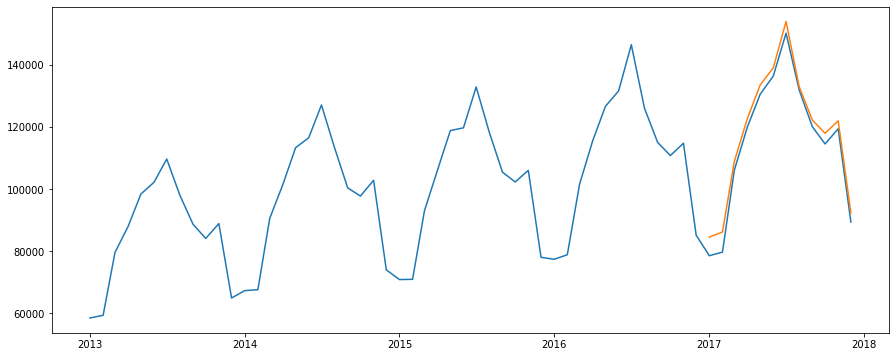

In [36]:
plt.figure(figsize=(15,6))
#plot the predictions for validation set
plt.plot(y.sales, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

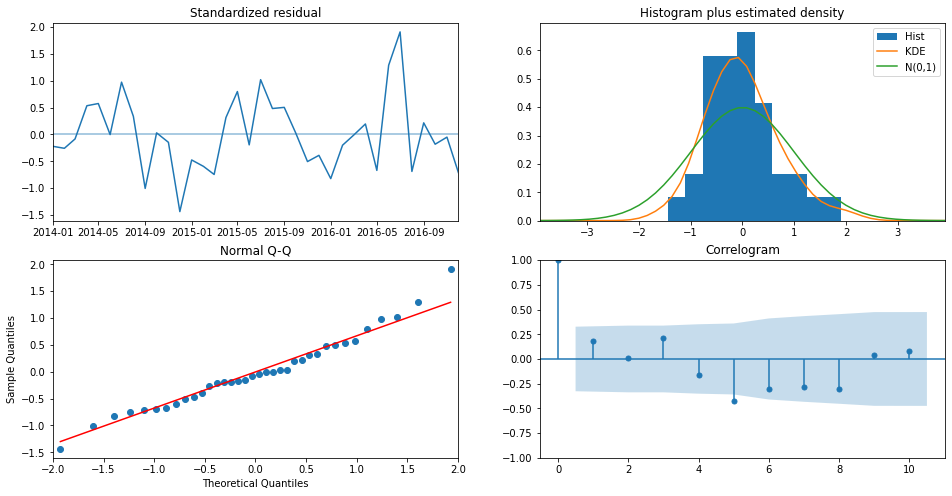

In [38]:
model_sarima.plot_diagnostics(figsize=(16, 8))
plt.show()



El diagnóstico del modelo sugiere que el modelo residual se distribuye normalmente en función de lo siguiente:

* En la gráfica superior derecha, la línea roja de KDE sigue de cerca con la línea N (0,1). Donde, N (0,1) es la notación estándar para una distribución normal con media 0 y desviación estándar de 1. Esta es una buena indicación de que los residuos se distribuyen normalmente.

* La gráfica qq en la parte inferior izquierda muestra que la distribución ordenada de los residuos (puntos azules) sigue la tendencia lineal de las muestras tomadas de una distribución normal estándar. Nuevamente, esta es una fuerte indicación de que los residuos se distribuyen normalmente.

* Esto se confirma mediante el gráfico de autocorrelación (es decir, correlograma) en la parte inferior derecha, que muestra que los residuos de series temporales tienen una baja correlación con versiones rezagadas de sí mismo.


* Evaluando predicciones en valid:

In [37]:
evaluate_forecast(y[start_index:end_index], forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,rmse
0,0.972126,3292.967155,2870.157394,1.299399e+07,0.001411,3604.71829




*   Vemos que las métricas del modelo son bastante buenas



In [50]:
data_test_proy["Sarima_Predictions"] = forecast['Prediction'].values

## MODELOS DE SUAVIZAMIENTO EXPONENCIAL

In [52]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

### SimpleExpSmoothing

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:title={'center':'Single Exponential Smoothing'}, xlabel='fecha'>

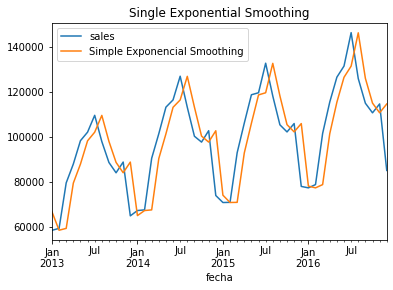

In [53]:
HWES1 = SimpleExpSmoothing(train, initialization_method="estimated").fit()
HWES1_fitted = HWES1.fittedvalues
HWES1_fitted.name = 'Simple Exponencial Smoothing'
pd.concat([train, HWES1_fitted], axis=1).plot(title='Single Exponential Smoothing')

In [54]:
results = pd.DataFrame(
    index=["SSE", "AIC", "BIC"])
results["Simple Exponencial"] = [HWES1.sse] + [HWES1.aic] + [HWES1.bic] 

### Double exponencial smoothing (DES)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


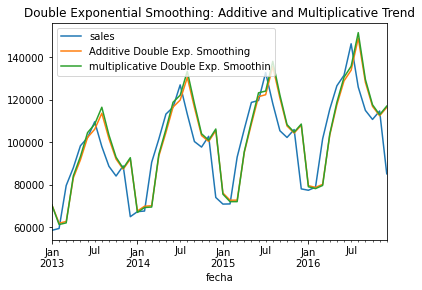

In [56]:
HWES2_ADD = ExponentialSmoothing(train,trend='add').fit()#.fittedvalues
HWES2_MUL = ExponentialSmoothing(train,trend='mul').fit()#.fittedvalues
HWES2_ADD_fitted = HWES2_ADD.fittedvalues
HWES2_MUL_fitted = HWES2_MUL.fittedvalues
HWES2_ADD_fitted.name = 'Additive Double Exp. Smoothing'
HWES2_MUL_fitted.name = 'multiplicative Double Exp. Smoothin'
pd.concat([train, HWES2_ADD_fitted, HWES2_MUL_fitted], axis=1).plot(title='Double Exponential Smoothing: Additive and Multiplicative Trend');

In [57]:
results["Double Exp. - Additive"] = [HWES2_ADD.sse] + [HWES2_ADD.aic] + [HWES2_ADD.bic] 
results["Double Exp. - Multiplicative"] = [HWES2_MUL.sse] + [HWES2_MUL.aic] + [HWES2_MUL.bic] 

### Triple exponencial smoothing (TES)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


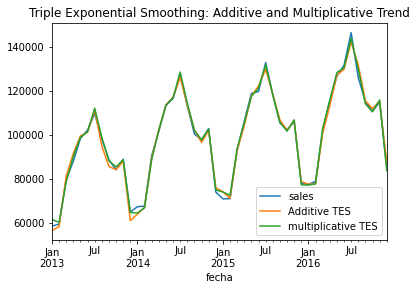

In [58]:
HWES3_ADD = ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=12).fit()
HWES3_MUL = ExponentialSmoothing(train,trend='mul',seasonal='mul',seasonal_periods=12).fit()

HWES3_ADD_fitted = HWES3_ADD.fittedvalues
HWES3_MUL_fitted = HWES3_MUL.fittedvalues
HWES3_ADD_fitted.name = 'Additive TES'
HWES3_MUL_fitted.name = 'multiplicative TES'
pd.concat([train, HWES3_ADD_fitted, HWES3_MUL_fitted], axis=1).plot(title='Triple Exponential Smoothing: Additive and Multiplicative Trend');

In [59]:
results["Triple Exp. - Additive"] = [HWES3_ADD.sse] + [HWES3_ADD.aic] + [HWES3_ADD.bic] 
results["Triple Exp. - Multiplicative"] = [HWES3_MUL.sse] + [HWES3_MUL.aic] + [HWES3_MUL.bic] 

#### Resultados modelos exponenciales

In [61]:
results

,Simple Exponencial,Double Exp. - Additive,Double Exp. - Multiplicative,Triple Exp. - Additive,Triple Exp. - Multiplicative
SSE,8.422457e+09,8.769738e+09,9.431027e+09,1.881349e+08,9.857207e+07
AIC,9.151824e+02,9.211218e+02,9.246113e+02,7.607105e+02,7.296847e+02
BIC,9.189248e+02,9.286066e+02,9.320962e+02,7.906497e+02,7.596239e+02


* Notamos que Triple Exp. - Multiplicative tiene el menor valor AIC.

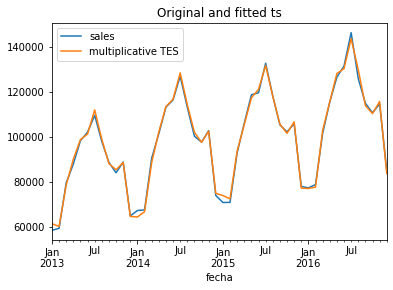

In [62]:
pd.concat([train, HWES3_MUL_fitted], axis=1).plot(title='Original and fitted ts');



*   Evaluación de predicciones en valid



In [72]:
HWES3_MUL_forecast = HWES3_MUL.forecast(12)
HWES3_MUL_forecast = pd.DataFrame( HWES3_MUL_forecast,index = valid.index,columns=['Prediction'])
HWES3_MUL_forecast

,Prediction
fecha,
2017-01-01,83942.262574
2017-02-01,84429.403260
2017-03-01,110761.103276
2017-04-01,125440.415591
2017-05-01,139227.561952
2017-06-01,142785.882993
2017-07-01,156629.223130
2017-08-01,139848.162365
2017-09-01,125162.440057


In [73]:
evaluate_forecast(y[start_index:end_index], HWES3_MUL_forecast.Prediction.values) 
# recordando que y contiene toda la data y star_index/end_index representan los ultimos 12 periodos

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,rmse
0,0.920254,5894.022667,5775.861885,3.717437e+07,0.002638,6097.078423




*   Las métricas son buenas, pero los modelos anteriores fueron mejores.



In [74]:
data_test_proy["Triple_Exp_smoot_Predictions"] = HWES3_MUL_forecast.Prediction.values
data_test_proy

,ventas_reales,Prophet_Predictions,Sarima_Predictions,Triple_Exp_smoot_Predictions
fecha,,,,
2017-01-01,78544.0,83970.184349,84532.705976,83942.262574
2017-02-01,79702.0,84207.135212,86177.246036,84429.403260
2017-03-01,106083.0,111035.397322,108880.836832,110761.103276
2017-04-01,120031.0,124989.670997,122765.612258,125440.415591
2017-05-01,130474.0,138098.783411,133485.018346,139227.561952
2017-06-01,136355.0,142484.037024,138978.574470,142785.882993
2017-07-01,150105.0,156526.347595,153878.872117,156629.223130
2017-08-01,131863.0,137226.535607,132905.163300,139848.162365
2017-09-01,120038.0,123977.580282,122162.068577,125162.440057


### Holt-Winters

In [ ]:
fit1 = ExponentialSmoothing(
    train,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
).fit()

fit2 = ExponentialSmoothing(
    train,
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    initialization_method="estimated",
).fit()

fit3 = ExponentialSmoothing(
    train,
    seasonal_periods=12,
    trend="mul",
    seasonal="add",
    initialization_method="estimated",
).fit()

fit4 = ExponentialSmoothing(
    train,
    seasonal_periods=12,
    trend="mul",
    seasonal="mul",
    initialization_method="estimated",
).fit()

#### Resultado de modelos Holt-Winters

In [76]:
results2 = pd.DataFrame(
    index=["SSE", "AIC", "BIC"])

In [77]:
results2["Holt Trend-Add Seas-Add"] = [fit1.sse] + [fit1.aic] + [fit1.bic]
results2["Holt Trend-Add Seas-Mul"] = [fit2.sse] + [fit2.aic] + [fit2.bic]
results2["Holt Trend-Mul Seas-Add"] = [fit3.sse] + [fit3.aic] + [fit3.bic]
results2["Holt Trend-Mul Seas-Mul"] = [fit4.sse] + [fit4.aic] + [fit4.bic]

In [78]:
results2

,Holt Trend-Add Seas-Add,Holt Trend-Add Seas-Mul,Holt Trend-Mul Seas-Add,Holt Trend-Mul Seas-Mul
SSE,1.881349e+08,9.624704e+07,2.088765e+08,9.857207e+07
AIC,7.607105e+02,7.285389e+02,7.657305e+02,7.296847e+02
BIC,7.906497e+02,7.584781e+02,7.956698e+02,7.596239e+02


* Notamos que Holt Trend-Add Seas-Mul tiene el menor valor AIC.

In [81]:
HoltTrendAddSeasMul_fitted = fit2.fittedvalues
HoltTrendAddSeasMul_fitted.name = 'Holt Trend-Add Seas-Mul'

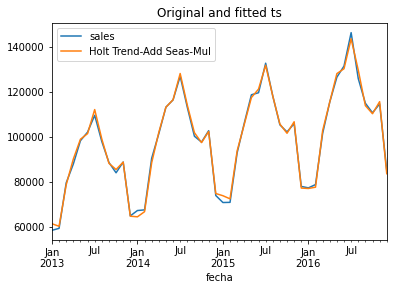

In [82]:
pd.concat([train, HoltTrendAddSeasMul_fitted], axis=1).plot(title='Original and fitted ts');

* Evaluando predicciones en valid

In [83]:
HoltTrendAddSeasMul_forecast = fit2.forecast(12)
HoltTrendAddSeasMul_forecast = pd.DataFrame( HoltTrendAddSeasMul_forecast,index = valid.index,columns=['Prediction'])
HoltTrendAddSeasMul_forecast

,Prediction
fecha,
2017-01-01,83875.179538
2017-02-01,84307.064893
2017-03-01,110524.325526
2017-04-01,125081.062797
2017-05-01,138722.224918
2017-06-01,142153.109318
2017-07-01,155803.737309
2017-08-01,138988.774050
2017-09-01,124279.337034


In [84]:
evaluate_forecast(y[start_index:end_index], HoltTrendAddSeasMul_forecast.Prediction.values)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,rmse
0,0.935415,5268.168862,5254.137604,3.010688e+07,0.00219,5486.973836


* La métrica es mejor respecto al modelo exponencial triple anterior.

In [85]:
data_test_proy["HoltTrendAddSeasMul_Predictions"] = HoltTrendAddSeasMul_forecast.Prediction.values
data_test_proy

,ventas_reales,Prophet_Predictions,Sarima_Predictions,Triple_Exp_smoot_Predictions,HoltTrendAddSeasMul_Predictions
fecha,,,,,
2017-01-01,78544.0,83970.184349,84532.705976,83942.262574,83875.179538
2017-02-01,79702.0,84207.135212,86177.246036,84429.403260,84307.064893
2017-03-01,106083.0,111035.397322,108880.836832,110761.103276,110524.325526
2017-04-01,120031.0,124989.670997,122765.612258,125440.415591,125081.062797
2017-05-01,130474.0,138098.783411,133485.018346,139227.561952,138722.224918
2017-06-01,136355.0,142484.037024,138978.574470,142785.882993,142153.109318
2017-07-01,150105.0,156526.347595,153878.872117,156629.223130,155803.737309
2017-08-01,131863.0,137226.535607,132905.163300,139848.162365,138988.774050
2017-09-01,120038.0,123977.580282,122162.068577,125162.440057,124279.337034


In [128]:
#guardado de dataframe pronostico
#data_test_proy.to_csv('/content/drive/MyDrive/Colab Notebooks/time_series/data_test_proy.csv', sep=';')

## EVALUACIÓN FINAL DE MODELOS

In [90]:
import plotly.graph_objects as go

In [91]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_test_proy.index, y=data_test_proy.ventas_reales,
                    mode='lines+markers',
                    name='ventas_reales'))

fig.add_trace(go.Scatter(x=data_test_proy.index, y=data_test_proy.Prophet_Predictions,
                    mode='lines+markers',
                    name='Prophet_Predictions'))

fig.add_trace(go.Scatter(x=data_test_proy.index, y=data_test_proy.Sarima_Predictions,
                    mode='lines+markers',
                    name='Sarima_Predictions'))

fig.add_trace(go.Scatter(x=data_test_proy.index, y=data_test_proy.Triple_Exp_smoot_Predictions,
                    mode='lines+markers',
                    name='Triple_Exp_smoot_Predictions'))

fig.add_trace(go.Scatter(x=data_test_proy.index, y=data_test_proy.HoltTrendAddSeasMul_Predictions,
                    mode='lines+markers',
                    name='HoltTrendAddSeasMul_Predictions'))

* Gráficamente observamos que SARIMA tiene mayor cercanía a los valores reales de la serie en los datos de validación

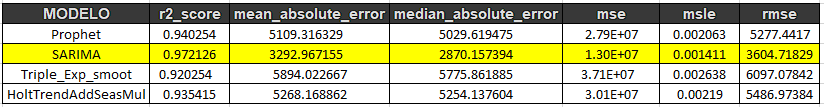



*   Utilizando las métricas obtenidas notamos que el mejor modelo es SARIMA debido a que obtuvo mejores valores en la evaluación de predicciones.


## PRONÓSTICO DE VENTAS FUTURAS

In [ ]:
#Predictions
forecast = model_sarima.predict(n_periods=24)
forecast = pd.DataFrame(forecast,columns=['Prediction'])

In [129]:
forecast.tail(12)

,Prediction
2018-01-01,92459.251130
2018-02-01,94049.398699
2018-03-01,116771.600784
2018-04-01,130688.467232
2018-05-01,141543.642704
2018-06-01,146810.098931
2018-07-01,161694.425035
2018-08-01,140952.013380
2018-09-01,130118.739644
2018-10-01,125869.636545


In [127]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast[:12].index, y=forecast[:12].Prediction,
                    mode='lines+markers',
                    name='Ventas último periodo'))

fig.add_trace(go.Scatter(x=forecast[11:].index, y=forecast[11:].Prediction,
                    mode='lines+markers',
                    name='Predicciones (2018)'))

fig.update_layout(
    title="Pronóstico de ventas(Store 2)",
    xaxis_title="MES",
    yaxis_title="MONTO")

* En el próximo mes se pronostican ventas con un valor de 92459.25

FIN.